# CPSC 422 - Assignment 2

## Question 2

This question relates to the following belief network where we are estimating the probability $P(r|s,w)$. In other words, we are estimating the probability of Rain ($r$) given that the Sprinkler is on ($S=T$) and the there is Wet Grass ($W=T$) using rejection sampling and likelihood weighting. The results of these samples are in `rs_1.csv` and `lw_1.csv` in the `data` folder.

![Weather Network](img/A2Q2.png) 

### Part A: Calculate and graph $P(r|s,w)$ versus the number of samples N using rejection sampling. Approximate $P(r|s,w)$ using 100000 samples.

Note, each line in `rs_1.csv` (rejection sampling results) contains a sample:
* -1 means the sample has been rejected
* 1 means $R=T$
* 2 means $R=F$

In [1]:
import pandas as pd
rs_1 = pd.read_csv('data/rs_1.csv', names=['sample'], header=None)
rs_1.index += 1
rs_1.head()

,sample
1,-1
2,2
3,-1
4,-1
5,-1


The following function takes a set of samples and computes the $P(r|s,w)$ for each sample $N$ using samples $1:N$:

In [2]:
def computeProbability(samples):
    p = []
    trueSamples = 0
    countedSamples = 0
    for i in range(len(samples)):
        sample = samples[i]
        if i == 0 and sample == -1 or sample == -1 and p[i-1] == None:
            p.append(None)                                               # SHOULD THIS BE A UNIFORM DISTRIBUTION OF 0.5 ON EACH?
        elif sample == -1:
            p.append(p[i-1])
        else:
            trueSamples += (sample==1)
            countedSamples += 1
            p.append(trueSamples/countedSamples)
    return p

Therefore, we can calculate the following:

In [3]:
rs_1['P(r|s,w)'] = computeProbability(list(rs_1['sample']))
rs_1.head()

,sample,"P(r|s,w)"
1,-1,NaN
2,2,0.0
3,-1,0.0
4,-1,0.0
5,-1,0.0


Finally, we plot the results on a logarithmic axis to examine behavior for small sample sizes:

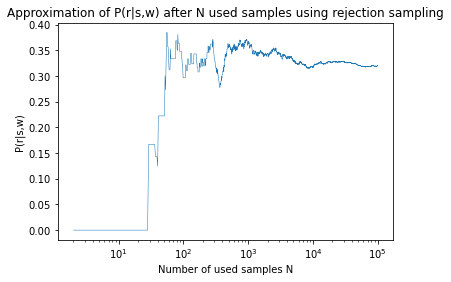

In [4]:
import matplotlib.pyplot as plt
plt.plot(rs_1.index, rs_1['P(r|s,w)'], linewidth=0.5)
plt.xscale('log',base=10)
plt.title("Approximation of P(r|s,w) after N used samples using rejection sampling");
plt.ylabel("P(r|s,w)");
plt.xlabel("Number of used samples N");

**Therefore:** The rejection sampling algorithm's approximation of $P(r|s,w)$ after 100000 samples is:

In [5]:
rs_1['P(r|s,w)'].iloc[-1]

0.3198136868505912

### Part B: Using Hoeffding's inequality, derive the tightest bound $\epsilon$ such that $P(|s-p|>\epsilon)<0.05$. How many accepted samples are there? What is the value of $\epsilon$ for that number of accepted samples? Add upper and lower confidence bounds using $s \pm \epsilon$.

Here, $p$ represents the true $P(r|s,w)$, $s$ represents the approximation of $p$ after rejection sampling on $n$ accepted samples.

Hoeffding's inequality is: $2e^{-2n\epsilon^2} < \delta$. Solving for $\epsilon$:

$2e^{-2n\epsilon^2} < \delta$

$\frac{1}{e^{2n\epsilon^2}} < \frac{\delta}{2}$

$\frac{2}{\delta} < e^{2n\epsilon^2}$

$\ln{(\frac{2}{\delta})} < 2n\epsilon^2$

$\frac{\ln{(\frac{2}{\delta})}}{2n} < \epsilon^2$

$\sqrt{\frac{\ln{(\frac{2}{\delta})}}{2n}} < \epsilon$

Note that we know $\delta = 0.05$ as specified in the question.

The following function implements the mathematical derivation above:

In [6]:
import math
def computeOneEpsilon(n, delta=0.05):
    return math.sqrt(math.log(2/delta)/(2*n))

The following function takes a set of samples and computes $\epsilon$ for each sample $N$ using samples $1:N$:

In [7]:
def computeEpsilon(samples):
    e = []
    countedSamples = 0
    for i in range(len(samples)):
        sample = samples[i]
        if i == 0 and sample == -1 or sample == -1 and e[i-1] == None:
            e.append(None)
        elif sample == -1:
            e.append(e[i-1])
        else:
            countedSamples += 1
            e.append(computeOneEpsilon(countedSamples))
    return e

We define another function to compute the error bounds $s \pm \epsilon$:

In [8]:
def computeErrorBounds(approximations, epsilons):
    upper = []
    lower = []
    assert(len(approximations)==len(epsilons))
    for i in range(len(approximations)):
        s = approximations[i]
        e = epsilons[i]
        if math.isnan(s) or math.isnan(e):
            upper.append(None)
            lower.append(None)
        else:
            upper.append(min(1,s+e)) # We bound the values of our error bars, because it doesn't
            lower.append(max(0,s-e)) # make sense to have a probability > 1 or < 0.
    return upper,lower

These functions can now be used to add error bounds to our approximations:

In [9]:
rs_1['epsilon'] = computeEpsilon(list(rs_1['sample']))
upperBound, lowerBound = computeErrorBounds(list(rs_1['P(r|s,w)']),list(rs_1['epsilon']))
rs_1['upperBound'] = upperBound
rs_1['lowerBound'] = lowerBound
rs_1.head()

,sample,"P(r|s,w)",epsilon,upperBound,lowerBound
1,-1,NaN,NaN,NaN,NaN
2,2,0.0,1.358102,1.0,0.0
3,-1,0.0,1.358102,1.0,0.0
4,-1,0.0,1.358102,1.0,0.0
5,-1,0.0,1.358102,1.0,0.0


Finally, we can plot the approximations of rejection sampling with error bounds:

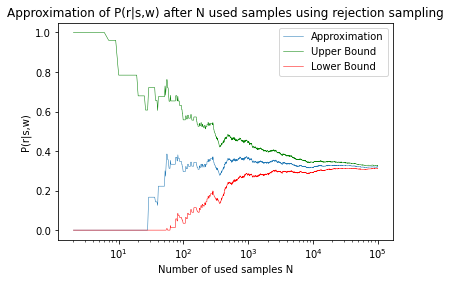

In [10]:
plt.plot(rs_1.index, rs_1['P(r|s,w)'], linewidth=0.5)
plt.plot(rs_1.index, rs_1['upperBound'], linewidth=0.5, c='g')
plt.plot(rs_1.index, rs_1['lowerBound'], linewidth=0.5, c='r')
plt.xscale('log',base=10)
plt.title("Approximation of P(r|s,w) after N used samples using rejection sampling");
plt.ylabel("P(r|s,w)");
plt.xlabel("Number of used samples N");
plt.legend(labels=['Approximation', 'Upper Bound', 'Lower Bound']);

**Therefore:** The number of accepted samples $n$ and respective value of $\epsilon$ for that $n$ is:

In [11]:
acceptedSamples = rs_1['sample'].value_counts().loc[1] + rs_1['sample'].value_counts().loc[2]
print(f"Number of accepted samples: {acceptedSamples}")
print(f"Respective value of epsilon: {computeOneEpsilon(acceptedSamples)}")

Number of accepted samples: 27910
Respective value of epsilon: 0.008129284366775905


### Part C: Calculate and graph $P(r|s,w)$ versus the number of samples N using likelihood weighting. Approximate $P(r|s,w)$ using 100000 samples. Does likelihood weighting or rejection sampling converge faster?

Note, each line in `lw_1.csv` (likelihood weighting) contains a sample:
* The first column denotes the sample, where 1 means $R=T$ and 2 means $R=F$
* The second column denotes the weight of the sample

In [12]:
lw_1 = pd.read_csv('data/lw_1.csv', names=['sample','weight'], header=None)
lw_1.index += 1
lw_1.head()

,sample,weight
1,2,0.450
2,1,0.495
3,2,0.090
4,2,0.450
5,2,0.450


Just like before, the following function takes a set of samples and computes the $P(r|s,w)$ for each sample $N$ using samples $1:N$:

In [13]:
def computeProbabilityLikelihoodWeighting(samples, weights):
    p = []
    trueSamples = 0
    falseSamples = 0
    assert(len(samples)==len(weights))
    for i in range(len(samples)):
        sample = samples[i]
        weight = weights[i]
        if sample == 1:
            trueSamples += weight
        elif sample == 2:
            falseSamples += weight
        p.append(trueSamples/(trueSamples+falseSamples))
    return p

Therefore, we can compute the following:

In [14]:
lw_1['P(r|s,w)'] = computeProbabilityLikelihoodWeighting(list(lw_1['sample']), list(lw_1['weight']))
lw_1.head()

,sample,weight,"P(r|s,w)"
1,2,0.450,0.000000
2,1,0.495,0.523810
3,2,0.090,0.478261
4,2,0.450,0.333333
5,2,0.450,0.255814


Finally, we can plot the approximations made by likelihood weighting:

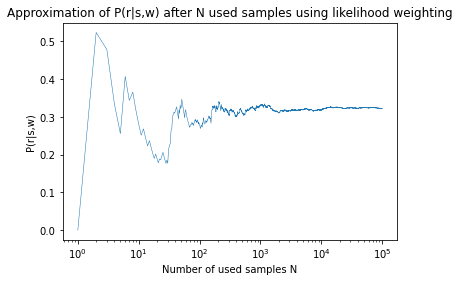

In [15]:
plt.plot(lw_1.index, lw_1['P(r|s,w)'], linewidth=0.5)
plt.xscale('log',base=10)
plt.title("Approximation of P(r|s,w) after N used samples using likelihood weighting");
plt.ylabel("P(r|s,w)");
plt.xlabel("Number of used samples N");

In [16]:
print(f"After 100000 iterations, the approximation of P(r|s,w) is: {lw_1['P(r|s,w)'].iloc[-1]}, which is similar to the value from rejection sampling")

After 100000 iterations, the approximation of P(r|s,w) is: 0.3217877911582522, which is similar to the value from rejection sampling


**Therefore:** Likelihood weighting seems to converge faster given that it gets closer to final approximation after $10^3$ used samples, whereas rejection sampling seems to get close after $10^4$ used samples. This makes sense, because every value of likelihood weighting is used to better approximate $P(r|s,w)$, whereas in rejection sampling, values that are rejected (-1) add to the number of used samples, but do not improve the approximation.